In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install jitcdde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jitcdde: filename=jitcdde-1.8.1-py3-none-any.whl size=55003 sha256=f214b82a463560c73aeb46c973726cd84669cca040e8ab190397a3e8e158f0c9
  Stored in directory: /root/.cache/pip/wheels/42/e3/4e/94b61188e5e3e62ba27e9586da5ecc7ea0f24e26916a250cc7
  Created wheel for chspy: filename=CHSPy-1.2.2-py3-none-any.whl size=11999 sha256=a1ba4f81cb412c66ba53d3f7a466cfbbaf232de24767730c9c8f18a63e4683ff
  Stored in directory: /root/.cache/pip/wheels/11/17/24/0cca70842afd051f54325b813e637d8e8836d88c286ba63fae
  Created wheel for jitcxde_common: filename=jitcxde_common-1.5.4-py3-none-any.whl size=16755 sha256=9ee8f906a6050351761f93b85dc9ee246ae189a8f41aa8b050307af7c6d2c72b
  Stored in directory: /root/.cach

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jitcdde import jitcdde, y, t
from numpy import pi, arange, random, max
import symengine
from scipy.signal import welch

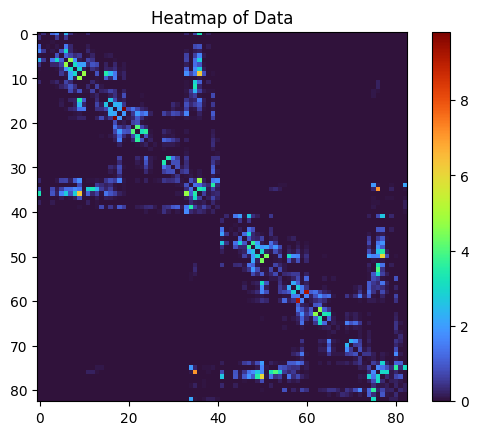

In [4]:
weight_filename = "gdrive/MyDrive/PBM-report2/WeightedA33.dat"
mapping_filename = "gdrive/MyDrive/PBM-report2/Nodes33.dat"
fiber_length_filename = "gdrive/MyDrive/PBM-report2/LengthFibers33.dat"

w_kj = np.loadtxt(weight_filename)
num_nodes = w_kj.shape[0]

# Plot the heatmap using matplotlib
plt.imshow(w_kj, cmap='turbo', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Data')
plt.show()

In [13]:
# Define the differential equation model
def dcdt(c_k, q_k, w_kj, alpha):
    # Define the graph Laplacian matrix L
    D = np.diag(w_kj.sum(axis=1))
    L = rho * (D - w_kj)
    return -L.dot(c_k) + alpha * c_k * (1 - c_k)

def dqdt(c_k, q_k, beta):
    return beta * c_k * (1 - q_k)

def dwdt(w_kj, q_k, gamma):
    q_sum = q_k[:, None] + q_k  # Calculate the sum of damage
    return -gamma * w_kj * q_sum

# Integrate the model equations
def model(y, t, beta, gamma):
    num_variables = 2 * num_nodes + num_nodes**2
    c_k = y[:num_nodes]
    q_k = y[num_nodes:2*num_nodes]
    w_kj = y[2*num_nodes:num_variables].reshape((num_nodes, num_nodes))

    # Calculate dc/dt, dq/dt, dw/dt
    dc_dt = dcdt(c_k, q_k, w_kj, alpha)
    dq_dt = dqdt(c_k, q_k, beta)
    dw_dt = dwdt(w_kj, q_k, gamma).flatten()

    # Merge them back into a flat array
    dydt = np.concatenate((dc_dt, dq_dt, dw_dt))
    return dydt

In [14]:
# Initialize c_k (toxic protein concentration), q_k (node damage), and w_kj (edge weight)
c_k = np.zeros(num_nodes)
q_k = np.zeros(num_nodes)

seed_protein_concentration = 0.025

# Define model parameters
alpha = 0.75  # 3/4 per year
beta_severe = 1 / 4
gamma_severe = 1 / 8
rho = 1 / 100  # mm/yr, Laplacian rate constant

# Assume that the node indexes corresponding to the medial frontal area are 26 and 68
entorhinal_nodes = [26, 68]
for entorhinal_node in entorhinal_nodes:
    c_k[entorhinal_node-1] = seed_protein_concentration

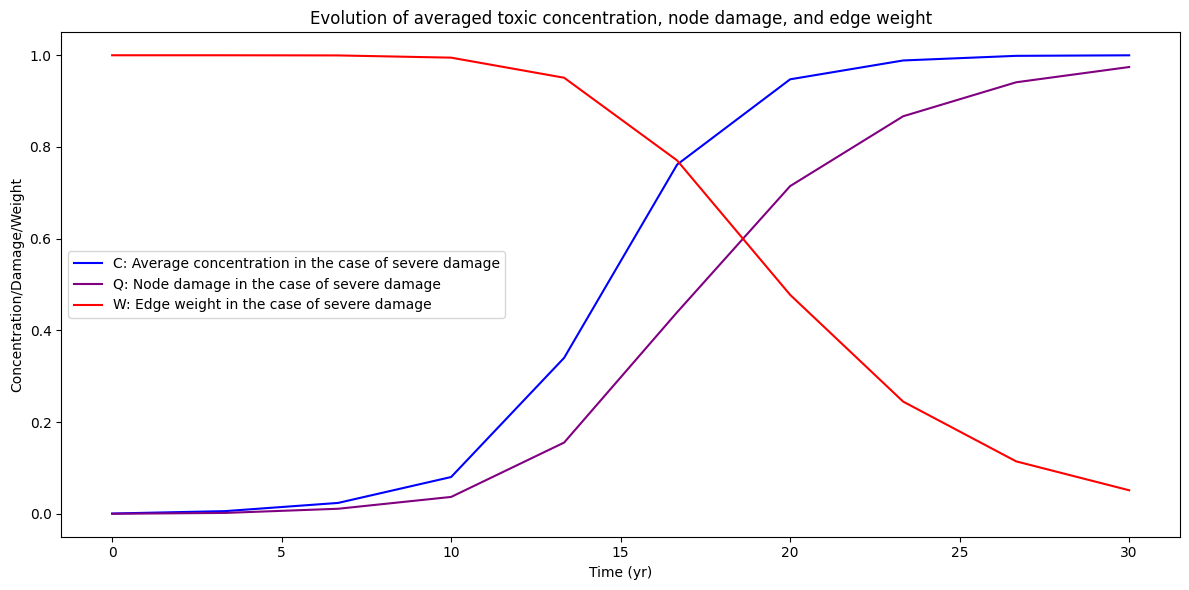

In [16]:
# Set the time points
transport_times = np.linspace(0, 30, 10) # From 0 to 30 years, a total of 1000 time points

# Set initial conditions
y0 = np.concatenate((c_k, q_k, w_kj.flatten()))

# Severe damage (β=1/4, γ=1/8)
sol_severe = odeint(model, y0, transport_times, args=(beta_severe, gamma_severe))
c_k_severe = sol_severe[:, :num_nodes]
q_k_severe = sol_severe[:, num_nodes:2*num_nodes]
w_kj_severe = sol_severe[:, 2*num_nodes:].reshape((len(transport_times), num_nodes, num_nodes))
C_T_severe = c_k_severe.mean(axis=1)
Q_severe = q_k_severe.mean(axis=1)
W_severe = np.array([np.linalg.norm(w) / np.linalg.norm(w_kj) for w in w_kj_severe])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(transport_times, C_T_severe, 'b-', label='C: Average concentration in the case of severe damage')
plt.plot(transport_times, Q_severe, color="purple", label='Q: Node damage in the case of severe damage')
plt.plot(transport_times, W_severe, 'r-', label='W: Edge weight in the case of severe damage')
plt.title('Evolution of averaged toxic concentration, node damage, and edge weight')
plt.xlabel('Time (yr)')
plt.ylabel('Concentration/Damage/Weight')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
tau_kj = np.loadtxt(fiber_length_filename)
tau_kj = tau_kj/1500

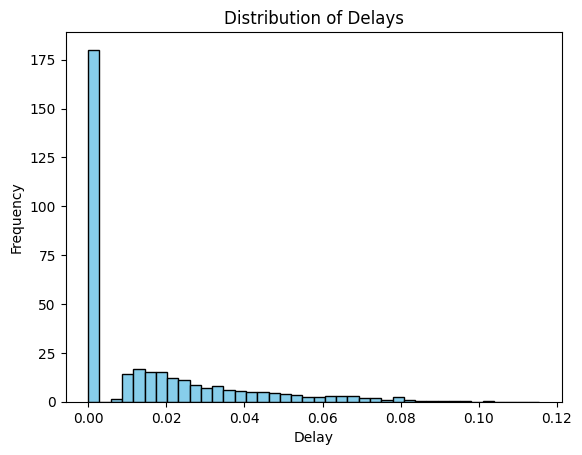

In [9]:
# Plot the distribution of delays, excluding zero
plt.hist(tau_kj.ravel(), bins=40, density=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Delays')
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.show()

In [10]:
# We flatten the array for the qcut function and then reshape it back to the original shape.
discretized_data, bins = pd.qcut(tau_kj.ravel(), 40, retbins=True, labels=False, duplicates='drop')

# Calculate the mean of the bins
bin_means = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map discretized data to the mean of the interval
discretized_tau_kj = np.array([bin_means[i] for i in discretized_data])
discretized_tau_kj = discretized_tau_kj.reshape(tau_kj.shape)

In [9]:
discretized_tau_kj.shape

(83, 83)

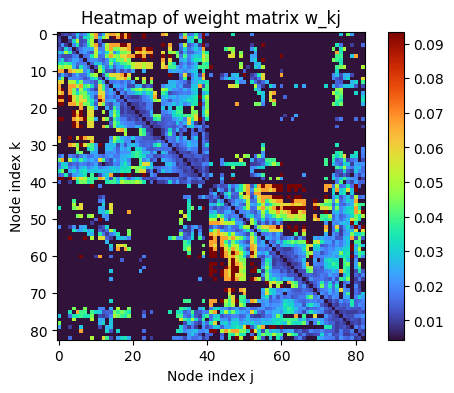

In [10]:
# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(discretized_tau_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [5]:
def sigmoid(x):
    return 1 / (1 + symengine.exp(-x))


def compute_metrics(excitatory, inhibitory, dt, nperseg=None):
    """
    Compute the metrics for the provided excitatory and inhibitory signals.

    Parameters:
    excitatory (np.array): Array of excitatory signals with shape (time_steps, num_nodes)
    inhibitory (np.array): Array of inhibitory signals with shape (time_steps, num_nodes)
    fs (float): Sampling frequency of the signals.
    nperseg (int): Length of each segment for Welch's method.

    Returns:
    tuple: Tuple containing the power P(T), average oscillatory activity A(T), metastability index B(T)
    """
    fs = 1/dt
    # Combine excitatory and inhibitory signals into a complex signal z
    z = excitatory + 1j * inhibitory

    # Compute the mean signal across all nodes (average order parameter)
    avg_z = np.mean(z, axis=1)

    # Calculate Power Spectral Density of the mean signal using Welch's method
    f, psd = welch(avg_z, fs=fs, nperseg=nperseg)

    # Integrate the PSD over the frequency range Gamma (you'll need to define this range)
    # Assuming Gamma is the entire frequency range for this example
    # For a specific range, you would restrict the integration to the indices corresponding to that frequency range
    P_T = np.trapz(psd, f)

    # Compute A(T) and B(T) as before
    A_T = np.mean(np.trapz(np.abs(z), dx=1/fs, axis=0))
    B_T = np.mean(np.var(np.abs(z), axis=0))

    print(f"P_T:{P_T}, A_T:{A_T}, B_T:{B_T}")

    return P_T, A_T, B_T


# def compute_metrics(excitatory, inhibitory):
#     """
#     Compute the metrics for the provided excitatory and inhibitory signals.

#     Parameters:
#     excitatory (np.array): Array of excitatory signals with shape (time_steps, num_nodes)
#     inhibitory (np.array): Array of inhibitory signals with shape (time_steps, num_nodes)

#     Returns:
#     tuple: Tuple containing average order parameter, average oscillatory activity, metastability index
#     """
#     # Combine excitatory and inhibitory signals into a complex signal z
#     z = excitatory + 1j * inhibitory

#     # Average order parameter <z> across all nodes
#     avg_z = np.mean(z, axis=1)

#     # Average oscillatory activity A(T)
#     A_T = np.mean(np.trapz(np.abs(z), dx=1, axis=0))

#     # Metastability index B(T)
#     B_T = np.mean(np.var(np.abs(z), axis=0))

#     return avg_z, A_T, B_T

In [6]:
def simulate_rsd(w_kj):
  n = num_nodes
  mean_omega = 40
  variance_omega = 0.1
  ω = np.random.normal(mean_omega, np.sqrt(variance_omega), n)
  c = 42
  λ = -0.01
  A = w_kj
  τ = discretized_tau_kj
  k = 10

  def resting_state_model():
    for i in range(num_nodes):
      # calculate the coupling sum for excitatory population
      coupling_sum = sum( A[i,j]*y(2*j, t-τ[i,j]) for j in range(num_nodes) )
      # apply the sigmoid functuon to the coupling term
      coupling_term = sigmoid(coupling_sum)

      # Excitatory population equation
      yield λ * y(2*i) - ω[i]*y(2*i+1) - y(2*i) * (y(2*i)**2 + y(2*i+1)**2) + k*coupling_term

      # Inhibitory population equation
      yield λ * y(2*i+1) + ω[i]*y(2*i) - y(2*i+1) * (y(2*i)**2 + y(2*i+1)**2)

  I = jitcdde(resting_state_model,n=2*n,verbose=False,delays=τ.flatten())
  I.set_integration_parameters(rtol=0,atol=1e-5)

  I.constant_past( np.random.rand(n*2), time=0.0 )
  I.integrate_blindly( max(τ) , 0.01 )

  # Time span for integration (10 seconds)
  t_end = 12
  dt = 0.01  # Adjust dt to the desired time resolution
  times = np.arange(2, t_end, dt)
  data = np.zeros((len(times), n*2))  # Pre-allocate space for efficiency

  # for time in I.t + arange(0,10,0.01):
  #   print(I.integrate(time))

  # Integrate and store the data
  for i, time in enumerate(times):
      data[i] = I.integrate(time)

  exc = data[:,:83]
  inh = data[:,83:]
  return exc, inh, dt, times

In [45]:
w_kj

array([[0.        , 0.3508948 , 0.02078903, ..., 0.        , 0.        ,
        0.        ],
       [0.3508948 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02078903, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.30735192,
        0.16465042],
       [0.        , 0.        , 0.        , ..., 0.30735192, 0.        ,
        0.03672209],
       [0.        , 0.        , 0.        , ..., 0.16465042, 0.03672209,
        0.        ]])

In [46]:
w_kj_severe[0]

array([[0.        , 0.3508948 , 0.02078903, ..., 0.        , 0.        ,
        0.        ],
       [0.3508948 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02078903, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.30735192,
        0.16465042],
       [0.        , 0.        , 0.        , ..., 0.30735192, 0.        ,
        0.03672209],
       [0.        , 0.        , 0.        , ..., 0.16465042, 0.03672209,
        0.        ]])

In [11]:
exc, inh, dt, times = simulate_rsd(w_kj)

In [17]:
pt = []
at = []
bt = []
for w in w_kj_severe:
  print(w.shape)
  exc, inh, dt, times = simulate_rsd(w)
  PT, AT, BT = compute_metrics(exc, inh, dt)
  pt.append(PT)
  at.append(AT)
  bt.append(BT)

(83, 83)
P_T:0.7316762342972125, A_T:12.570892318753998, B_T:0.03068104155894823
(83, 83)
P_T:0.7668774287241082, A_T:12.395292323766647, B_T:0.07909444782596821
(83, 83)
P_T:0.7407658585104242, A_T:12.185211539382154, B_T:0.1218324107029119
(83, 83)
P_T:0.6886443994168627, A_T:12.014790603676452, B_T:0.14531092039529742
(83, 83)
P_T:0.7266503949818012, A_T:12.392493092797299, B_T:0.06180193954286507
(83, 83)
P_T:0.6932172942217006, A_T:12.055558135567292, B_T:0.04683948849357247
(83, 83)
P_T:0.5181674083130627, A_T:11.31978226134231, B_T:0.06103311352138449
(83, 83)
P_T:0.3179265312853028, A_T:9.77290534653524, B_T:0.051626467335156495
(83, 83)
P_T:0.1516026588691457, A_T:7.4556349048294015, B_T:0.04224955077069112
(83, 83)
P_T:0.06554418736025408, A_T:5.104245417935099, B_T:0.03014538054493349


In [12]:
compute_metrics(exc, inh, dt)

P_T:0.5605104579387801, A_T:12.448907934369178, B_T:0.045852117935077014


/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(0.5605104579387801, 12.448907934369178, 0.045852117935077014)

In [18]:
biomarkers = np.array([pt, at, bt])

# Save the numpy array to a file
np.save('gdrive/MyDrive/PBM-report2/dynamic_biomarkers.npy', biomarkers)

NameError: name 'times' is not defined

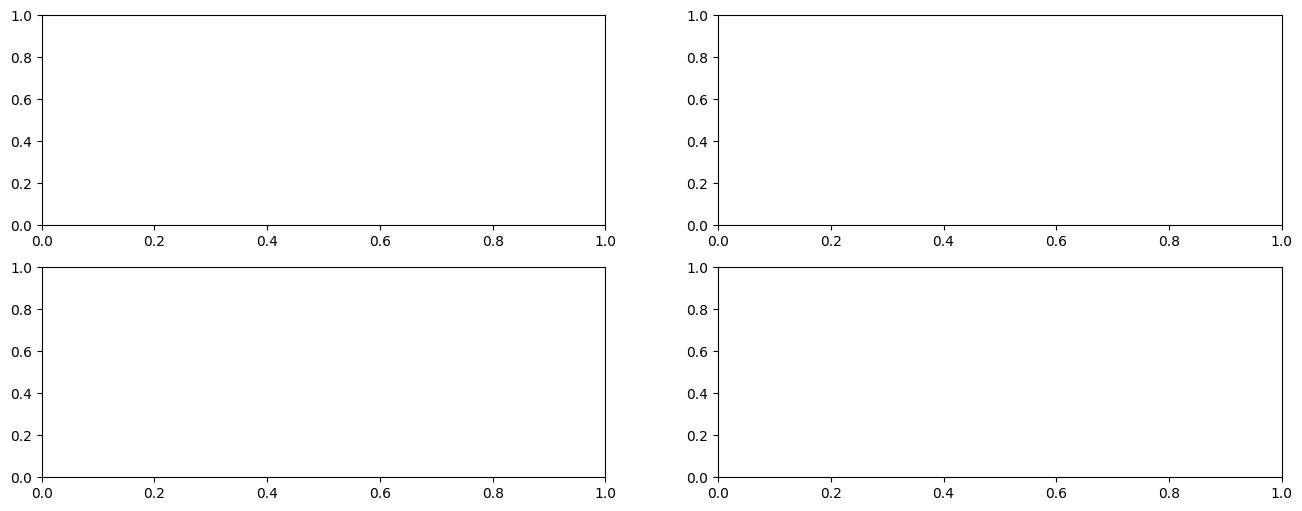

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16,6))

ax[0, 0].plot(times, exc[:,25], label="26th Excitatory")
ax[0, 1].plot(times, inh[:,25], label="26th Excitatory")

ax[1, 0].plot(times, exc[:,67], label="68th Excitatory")
ax[1, 1].plot(times, inh[:,67], label="68th Excitatory")

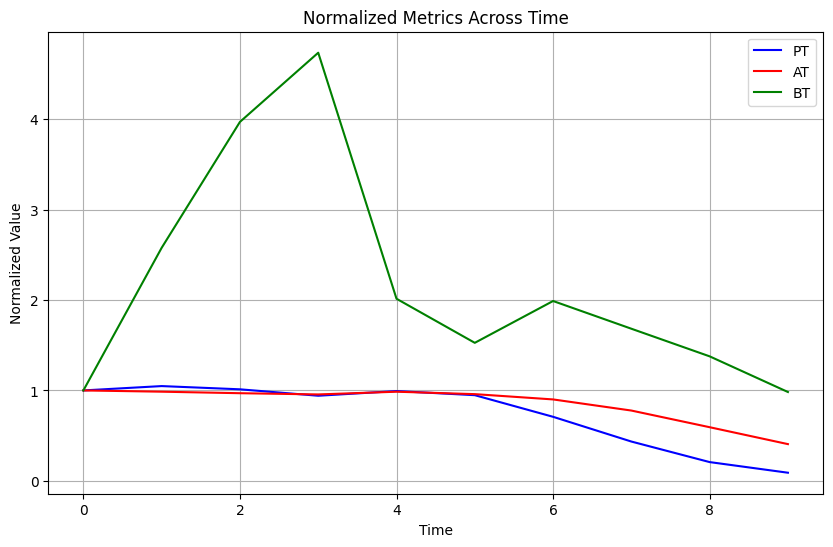

In [20]:
# Convert lists to NumPy arrays
pt_arr = np.array(pt)
at_arr = np.array(at)
bt_arr = np.array(bt)

# Normalize each array by dividing by its initial value
pt_arr_normalized = pt_arr / pt_arr[0]
at_arr_normalized = at_arr / at_arr[0]
bt_arr_normalized = bt_arr / bt_arr[0]

# Plot the normalized arrays against time
time = np.arange(len(pt))  # Assuming time steps are represented by indices
plt.figure(figsize=(10, 6))
plt.plot(time, pt_arr_normalized, label='PT', color='blue')
plt.plot(time, at_arr_normalized, label='AT', color='red')
plt.plot(time, bt_arr_normalized, label='BT', color='green')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.title('Normalized Metrics Across Time')
plt.legend()
plt.grid(True)
plt.show()